In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Malicious Macro Detection

/content/drive/MyDrive/Colab Notebooks/Malicious Macro Detection


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import string

from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

Loading data

In [4]:
train_set = pd.read_csv('train_dataset.csv', encoding='utf-16le')
val_set = pd.read_csv('validation_dataset.csv', encoding='utf-16le')
test_set = pd.read_csv('test_dataset.csv', encoding='utf-16le')

# creating dataframe of the full data for full data analyzing
data = pd.concat([train_set, val_set, test_set], ignore_index=True)
data.head()

,label,vba_code
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...
1,white,Option Explicit\nOption Explicit\nOption Expli...
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...


In [5]:
mapper = {
    'white': 1,
    'mal': 0
}

train_set['label'] = train_set['label'].map(mapper)
val_set['label'] = val_set['label'].map(mapper)
test_set['label'] = test_set['label'].map(mapper)
data['label'] = data['label'].map(mapper)

Ratio between labels

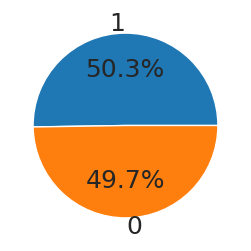

In [6]:
plt.figure(figsize=(8,3))
plt.pie(data['label'].value_counts(), labels=data['label'].unique().tolist(), autopct='%1.1f%%')
plt.show()

### Code Length and Words Count

Code length

In [7]:
data['Length'] = data['vba_code'].str.len()
data.head()

,label,vba_code,Length
0,1,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070
1,1,Option Explicit\nOption Explicit\nOption Expli...,13092
2,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428
3,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428
4,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428


Number of words in code

In [8]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [9]:
data['Word_count'] = data['vba_code'].apply(word_count)
data.head()

,label,vba_code,Length,Word_count
0,1,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070,149
1,1,Option Explicit\nOption Explicit\nOption Expli...,13092,1284
2,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,433
3,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,433
4,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,433


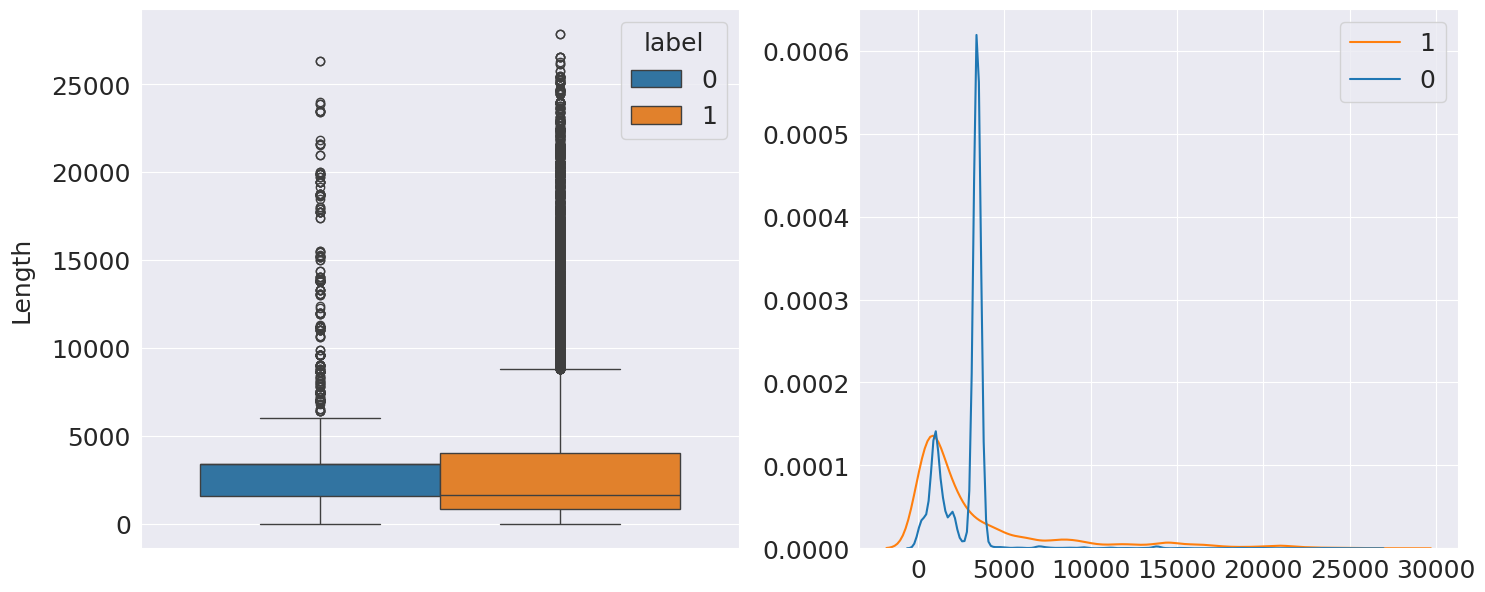

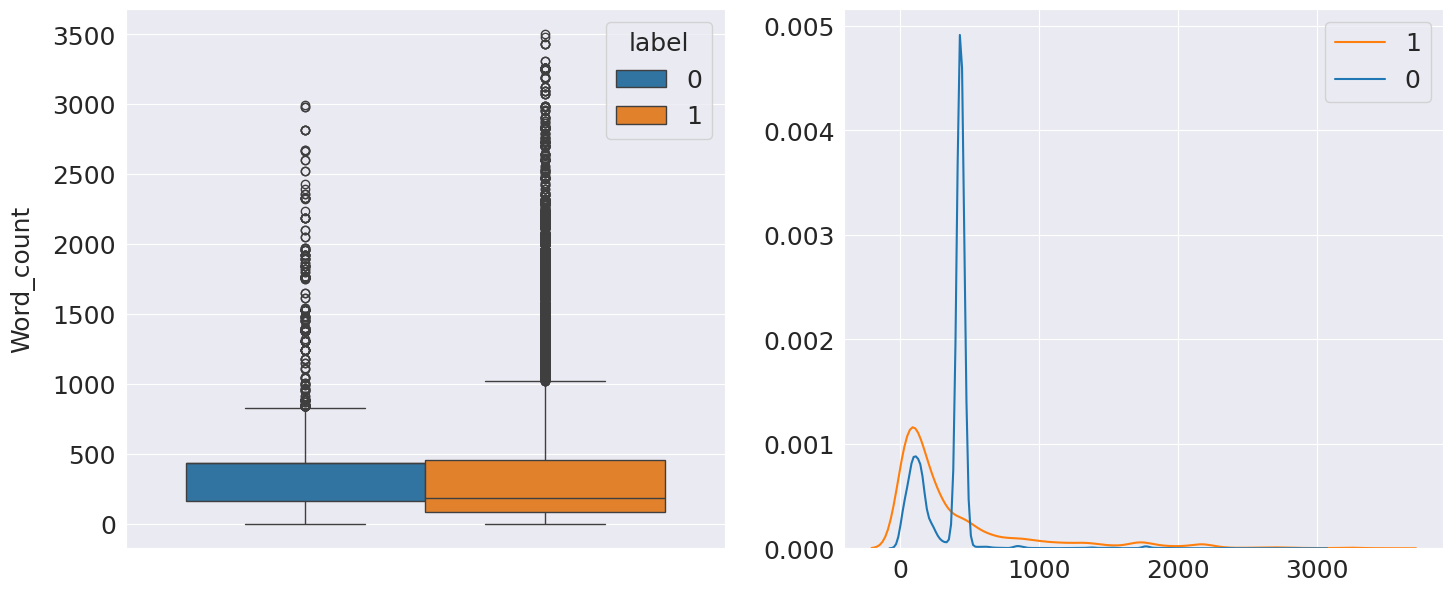

In [10]:
def visualize(col):

    print()
    plt.subplot(1,2,1)
    sns.boxplot(y=data[col], hue=data['label'])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1,2,2)
    melted_data = data.melt(id_vars=['label'], value_vars=[col], var_name='variable', value_name='value')
    sns.kdeplot(data=melted_data, x='value', hue='label')
    # sns.kdeplot(data[col], hue=data['label'])
    plt.legend(data['label'].unique())
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

features = data.columns.tolist()[2:]
for feature in features:
    visualize(feature)

### observations
1. In Avarage, Malicious codes are longer than white. In the same way,  malicious codes have more words than white in avarage.
2. On both terms, white codes are wider distributed than malicious codes.

### Words Frequencies

In [11]:
def corpus_to_list(text):
    text_list = text.split()
    return text_list

In [12]:
data['vba_code_list'] = data['vba_code'].apply(corpus_to_list)
data.head(10)

,label,vba_code,Length,Word_count,vba_code_list
0,1,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070,149,"[Private, Sub, Workbook_BeforeClose(Cancel, As..."
1,1,Option Explicit\nOption Explicit\nOption Expli...,13092,1284,"[Option, Explicit, Option, Explicit, Option, E..."
2,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,433,"['Option, Explicit, Private, Sub, Workbook_Bef..."
3,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,433,"['Option, Explicit, Private, Sub, Workbook_Bef..."
4,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,433,"['Option, Explicit, Private, Sub, Workbook_Bef..."
5,1,Option Explicit\n\n'Deklarationsbereich\nPriva...,2038,207,"[Option, Explicit, 'Deklarationsbereich, Priva..."
6,1,Sub ýÿýÿýÿýÿýÿýÿýÿýÿ()\nAttribute ýÿýÿýÿýÿýÿýÿ...,3716,272,"[Sub, ýÿýÿýÿýÿýÿýÿýÿýÿ(), Attribute, ýÿýÿýÿýÿý..."
7,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,433,"['Option, Explicit, Private, Sub, Workbook_Bef..."
8,1,Option Explicit\nOption Explicit\nOption Expli...,1403,151,"[Option, Explicit, Option, Explicit, Option, E..."
9,1,Private Sub Workbook_Open()\n\n'Se van mostrar...,1000,116,"[Private, Sub, Workbook_Open(), 'Se, van, most..."


In [13]:
data_white = data[data['label'] == 1].reset_index(drop=True)
data_mal = data[data['label'] == 0].reset_index(drop=True)

In [14]:
def remove_punctuation_and_numbers(text):
    "Create a translation table that maps punctuation and digits to None"
    translator = str.maketrans('', '', string.punctuation + string.digits)
    return text.translate(translator)

In [15]:
def most_common_grams(data):
  """
  Most frequent words in the corpus
  """

  data_no_punctuations = data['vba_code'].apply(remove_punctuation_and_numbers)
  data_no_punctuations = pd.DataFrame(data_no_punctuations, columns=['vba_code'])
  data_no_punctuations['vba_code_list'] = data_no_punctuations['vba_code'].apply(corpus_to_list)

  corpus = []
  for i in range(data_no_punctuations.shape[0]):
    corpus += data_no_punctuations['vba_code_list'][i]

  mostCommon = Counter(corpus).most_common(10)
  print(mostCommon)

  words = []
  freq = []
  for word, count in mostCommon:
      words.append(word)
      freq.append(count)
  sns.barplot(x=freq, y=words)
  plt.title('Top 10 Most Frequently Occuring Words')
  plt.show()

  return mostCommon

[('As', 440577), ('Sub', 377529), ('End', 289012), ('If', 229718), ('Dim', 192698), ('Private', 150952), ('Then', 147386), ('String', 98642), ('False', 80107), ('Public', 79856)]


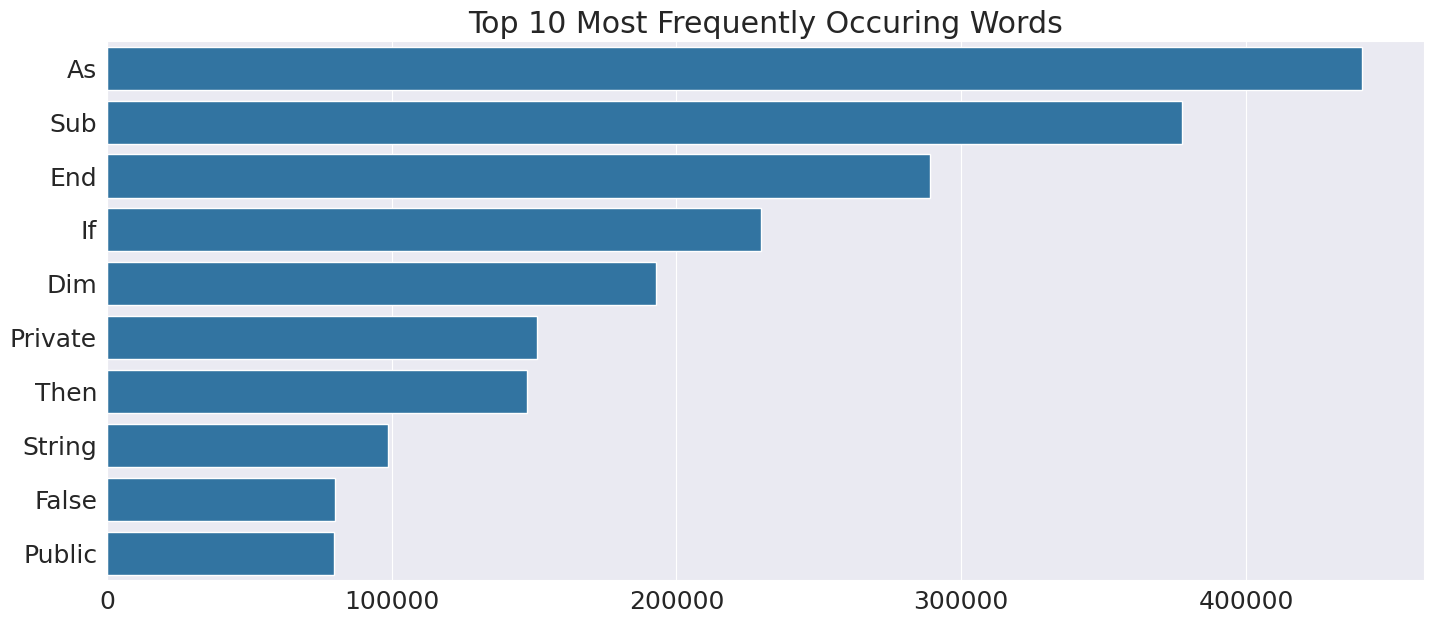


[('Sub', 253989), ('Value', 212490), ('ActiveSheetCells', 211372), ('Then', 197211), ('End', 195989), ('MsgBox', 178575), ('Call', 163616), ('BoQ', 158526), ('If', 154120), ('As', 151734)]


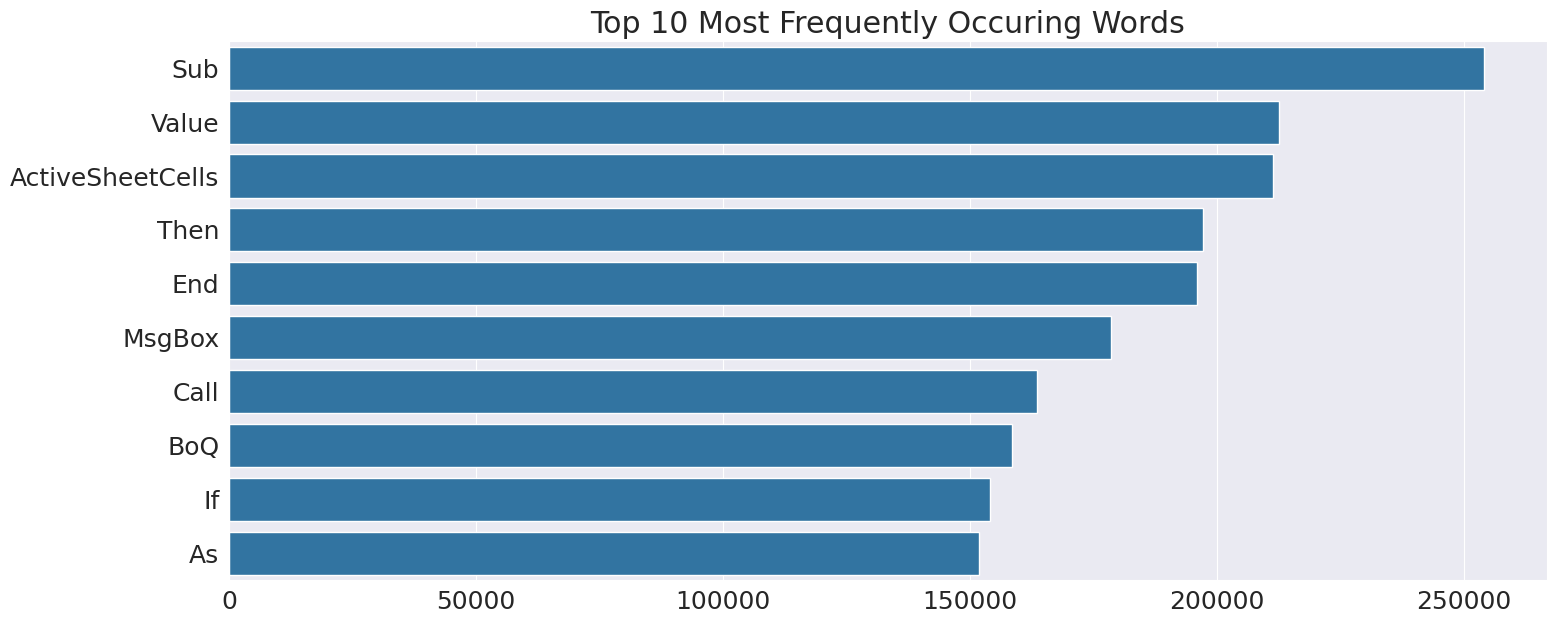

In [16]:
most_common_white = most_common_grams(data_white)
print()
most_common_mal = most_common_grams(data_mal)

The comparison between the two datasets reveals distinct patterns in the most common n-grams. The "white" dataset frequently includes programming structures such as 'As,' 'Sub,' and 'End,' typical of VBA code, suggesting generic or benign content. In contrast, the "mal" dataset includes terms like 'ActiveSheetCells,' 'MsgBox,' and 'Call,' which are more indicative of active interactions with Excel sheets or message boxes, potentially signaling malicious behavior. Both datasets share some common n-grams like 'Sub' and 'Then,' but their frequencies and contexts differ significantly.

### Word Clouds

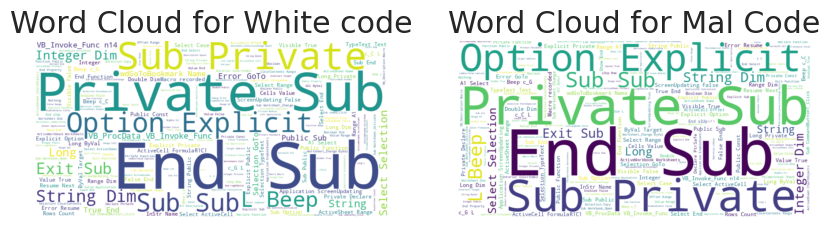

In [26]:
text_white = " ".join(data_white['vba_code'].tolist())
text_mal = " ".join(data_mal['vba_code'].tolist())

wordcloud_white = WordCloud(width=800, height=400, background_color='white').generate(text_white)
wordcloud_mal = WordCloud(width=800, height=400, background_color='white').generate(text_mal)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Word Cloud for White code')
plt.imshow(wordcloud_white, interpolation='bilinear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Word Cloud for Mal')
plt.imshow(wordcloud_mal, interpolation='bilinear')
plt.axis('off')

plt.show()

Both classes prominently feature programming keywords like "Private Sub", "End Sub", "Option Explicit", and "Dim", which are common in VBA. Notably, the word "Sub" appears to have a strong presence in both classes, suggesting the frequent use of subroutines. Despite these similarities, there might be subtle differences in the less frequent words that could hint at distinguishing patterns between the benign and malicious code samples.

### Top N-Grams

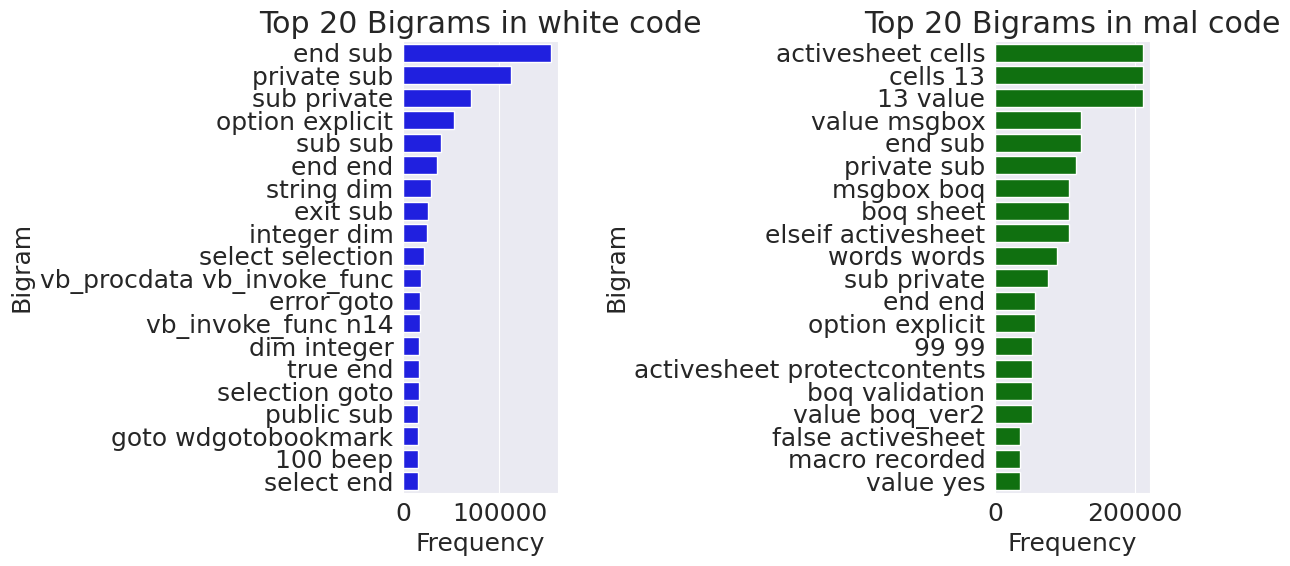

In [27]:
def get_top_ngrams(corpus, n=None, ngram_range=(2, 2)):
  """
  Calculating top n bigrams
  """
  vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
  return words_freq[:n]

top_bigrams_white = get_top_ngrams(data_white['vba_code'], n=20, ngram_range=(2, 2))
top_bigrams_mal = get_top_ngrams(data_mal['vba_code'], n=20, ngram_range=(2, 2))

df_bigrams_white = pd.DataFrame(top_bigrams_white, columns=['Bigram', 'Frequency'])
df_bigrams_mal = pd.DataFrame(top_bigrams_mal, columns=['Bigram', 'Frequency'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Frequency', y='Bigram', data=df_bigrams_white, color='blue')
plt.title('Top 20 Bigrams in white code')

plt.subplot(1, 2, 2)
sns.barplot(x='Frequency', y='Bigram', data=df_bigrams_mal, color='green')
plt.title('Top 20 Bigrams in mal code')

plt.tight_layout()
plt.show()

The bar charts depict the top 20 bigrams (two-word combinations) in both "White code" and "Mal code" samples. In the "White code" category, bigrams like "end sub," "private sub," and "option explicit" are highly frequent, indicating common coding structures and declarations typical of standard VBA scripts. Conversely, the "Mal code" bigrams highlight interactions with Excel objects and cells, such as "activesheet cells," "cells 13," and "value msgbox," suggesting manipulations of worksheet contents and user prompts, which may hint at potentially malicious behaviors. The divergence in bigram usage patterns between the two classes provides valuable insights into how each type of code functions and behaves.






